## Full methods comparison
This notebook will compare the integative conformal method to all benchmark methods discussed in the accompanying paper on different synthetic data models.

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sys.path.append('../methods')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data generation

In [5]:
from models import GaussianMixture, ConcentricCircles, ConcentricCircles2, ConcentricCirclesMixture, BinomialModel

random_state = 2022

model_name = "BinomialModel"

if model_name == "GaussianMixture":
    p = 20        # Number of features
    a = 0.25         # Signal amplitude
    model = GaussianMixture(p, a, random_state=random_state)
    purity = 0.8    # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "circles":
    p = 1000        # Number of features
    a = 0.7        # Signal amplitude
    model = ConcentricCirclesMixture(p, a, random_state=random_state)
    purity = 0.5      # Proportion of inliers
    n = 500          # Number of observations

elif model_name == "BinomialModel":
    p = 100        # Number of features
    a = 3          # Signal amplitude
    model = BinomialModel(p, a, random_state=random_state)
    purity = 0.9     # Proportion of inliers
    n = 1000          # Number of observations
    
else:
    print("Error: unknown model name!")
    
    
n_test = 1000     # Number of test points
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity)
X_test, Y_test = model.sample(n_test, purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 883.
Number of outliers in training/calibration data: 117.
Number of inliers in test data: 891.
Number of outliers in test data: 109.


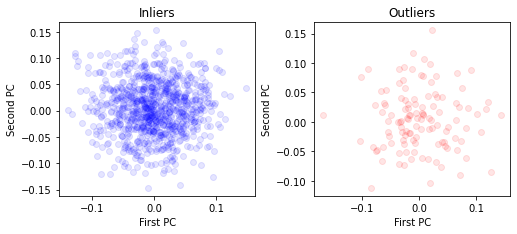

In [6]:
## Perform nonlinear PCA on an independent set of clean data
from sklearn.decomposition import KernelPCA

X_clean, _ = model.sample(n, purity=1)

pca = KernelPCA(kernel="rbf", n_components=2, gamma=0.01)
pca.fit(X_clean)

## Apply the nonlinear PCA separately to the inliers and outliers
X_in = X[Y==0]
pcs_in = pca.transform(X_in)

X_out = X[Y==1]
pcs_out = pca.transform(X_out)

## Plot the PCA results
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].scatter(pcs_in[:,0], pcs_in[:,1], alpha=0.1, color="blue")
axs[1].scatter(pcs_out[:,0], pcs_out[:,1], alpha=0.1, color="red")  
#axs[0].set_xlim(-0.5,0.5)
#axs[1].set_xlim(-0.5,0.5)
#axs[0].set_ylim(-0.5,0.5)
#axs[1].set_ylim(-0.5,0.5)
axs[0].set_xlabel("First PC")
axs[0].set_ylabel("Second PC")
axs[1].set_xlabel("First PC")
axs[1].set_ylabel("Second PC")
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## Conformal p-values via binary classification

In [7]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Define list of possible two-class classifiers with desired hyper-parameters
bbox_bc_list = [RandomForestClassifier(random_state=random_state),
                KNeighborsClassifier(),
                SVC(probability=True),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),   
                MLPClassifier(max_iter=500, random_state=random_state) 
               ]

# Choose a binary classifier algorithm
bbox_bc = bbox_bc_list[0]

Fitting the black-box model on 441 inliers and 117 outliers... done.
Calculating conformity scores for 442 hold-out inliers... done.
Calculating conformity scores for 1000 test points... done.


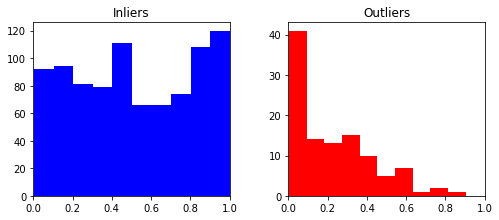

In [8]:
from methods_split import BinaryConformal

# Extract the inliers from the data
X_in = X[np.where(Y==0)[0]]
X_out = X[np.where(Y==1)[0]]

# Compute the p-values
method_binary = BinaryConformal(X_in, X_out, bbox_bc, calib_size=0.5, random_state=29)
pvals_binary = method_binary.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary[Y_test==0], color="blue")
axs[1].hist(pvals_binary[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conformal p-values via one-class classification

In [9]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf'),
                 svm.OneClassSVM(kernel='sigmoid'),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[3]

Fitting the black-box model on 441 data points... done.
Calculating conformity scores for 442 hold-out data points... done.
Calculating conformity scores for 1000 test points... done.


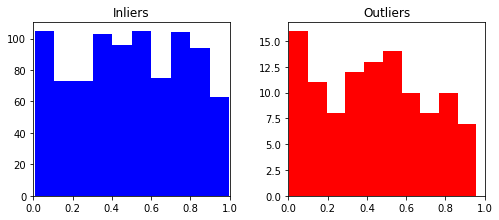

In [10]:
from methods_split import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conformal p-values via weighted one-class classification

Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 58 data points... done.


100%|██████████| 1000/1000 [00:02<00:00, 361.15it/s]


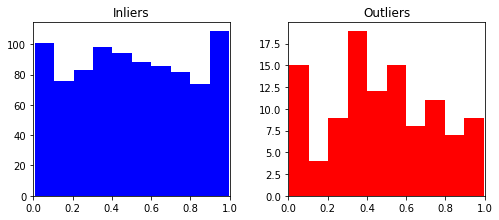

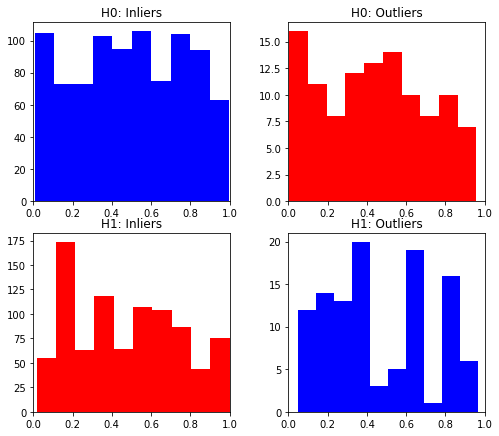

0.473833536976826

In [11]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = [bbox_occ]

# Compute the p-values
method_woc = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one, calib_size=0.5, tuning=True)
pvals_woneclass, pvals_woneclass_0, pvals_woneclass_1 = method_woc.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Plot the preliminary p-values
fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0,0].hist(pvals_woneclass_0[Y_test==0], color="blue")
axs[0,1].hist(pvals_woneclass_0[Y_test==1], color="red")  
axs[1,0].hist(pvals_woneclass_1[Y_test==0], color="red")
axs[1,1].hist(pvals_woneclass_1[Y_test==1], color="blue")  
axs[0,0].title.set_text('H0: Inliers')
axs[0,1].title.set_text('H0: Outliers')
axs[1,0].title.set_text('H1: Inliers')
axs[1,1].title.set_text('H1: Outliers')
axs[0,0].set_xlim(0,1)
axs[0,1].set_xlim(0,1)
axs[1,0].set_xlim(0,1)
axs[1,1].set_xlim(0,1)
plt.show()

np.mean(pvals_woneclass[Y_test==1])

## Integrative (one-class only) weighted ensemble

Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.


100%|██████████| 1000/1000 [00:07<00:00, 136.89it/s]


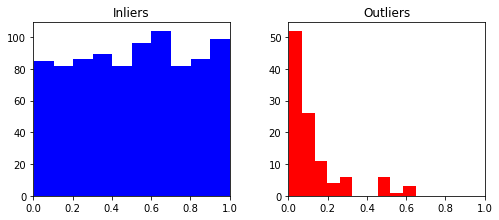

In [12]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_woc_ens = IntegrativeConformal(X_in, X_out, 
                                           bboxes_one=bboxes_one, bboxes_two=[],
                                           calib_size=0.5, ratio=True, tuning=True)
pvals_woneclass_ens = method_woc_ens.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_woneclass_ens[Y_test==0], color="blue")
axs[1].hist(pvals_woneclass_ens[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Binary ensemble (unweighted)

Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... 

c:\Users\liang\anaconda3\envs\py37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done.


100%|██████████| 1000/1000 [00:04<00:00, 225.50it/s]


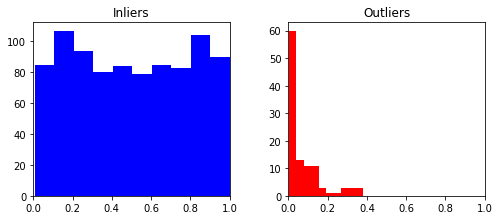

In [13]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_bin_ens = IntegrativeConformal(X_in, X_out, 
                                           bboxes_two=bboxes_two,
                                           calib_size=0.5, ratio=False, tuning=True)
pvals_bin_ens = method_bin_ens.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_bin_ens[Y_test==0], color="blue")
axs[1].hist(pvals_bin_ens[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Unweighted OCC ensemble

Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.


100%|██████████| 1000/1000 [00:04<00:00, 209.50it/s]


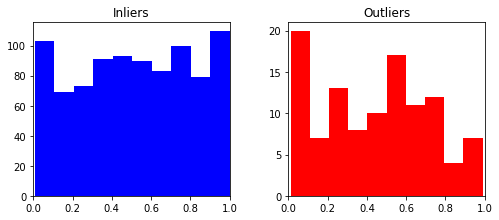

In [14]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_unw_ens = IntegrativeConformal(X_in, X_out, 
                                           bboxes_one=bboxes_one, #bboxes_two=bboxes_two,
                                           calib_size=0.5, ratio=False, tuning=True)
pvals_unw_ens = method_unw_ens.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_unw_ens[Y_test==0], color="blue")
axs[1].hist(pvals_unw_ens[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Integrative method

Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 441 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a one-class classification model on 58 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification model on 499 data points... done.
Fitting a two-class classification mode

c:\Users\liang\anaconda3\envs\py37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done.


100%|██████████| 1000/1000 [00:10<00:00, 93.04it/s]


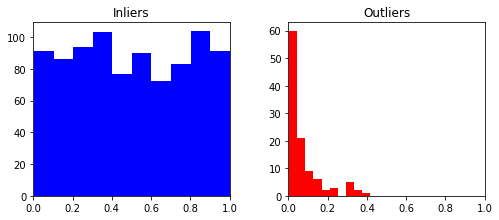

In [15]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_int = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one, bboxes_two=bboxes_two,
                                       calib_size=0.5, tuning=True)
pvals_int, pvals_int_0, pvals_int_1 = method_int.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int[Y_test==0], color="blue")
axs[1].hist(pvals_int[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Compare all p-values

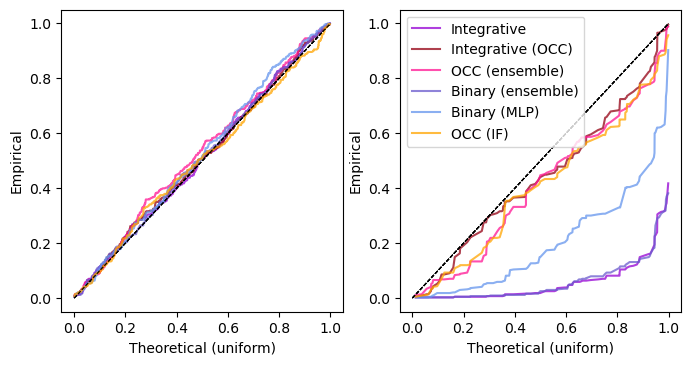

In [16]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_int[Y_test==y], U[Y_test==y], axs[y], label="Integrative", color='#9400d3',
            logarithm=logarithm)
    qq_plot(pvals_woneclass[Y_test==y], U[Y_test==y], axs[y], label="Integrative (OCC)", color='#940013',
            logarithm=logarithm)
    qq_plot(pvals_unw_ens[Y_test==y], U[Y_test==y], axs[y], label="OCC (ensemble)", color='#ff1493',
            logarithm=logarithm)
    qq_plot(pvals_bin_ens[Y_test==y], U[Y_test==y], axs[y], label="Binary (ensemble)", color='#6a5acd',
            logarithm=logarithm)
    qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary (MLP)", color="#6495ED",
            logarithm=logarithm)
    qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="OCC (IF)", color='#FFA500',
            logarithm=logarithm)

plt.legend()
plt.show()

In [17]:
## Make figure for paper
if False:      
    fig, axs = plt.subplots(1,2, figsize=(7.5,3.2), dpi= 100)

    axs[0].set_title("Inliers")
    axs[1].set_title("Outliers")
    logarithm = False
    U = np.random.uniform(size = (len(Y_test),))
    for y in [0,1]:
        qq_plot(pvals_woneclass_ens[Y_test==y], U[Y_test==y], axs[y], label="Integrative", color='#9400d3',
                logarithm=logarithm)
        qq_plot(pvals_woneclass[Y_test==y], U[Y_test==y], axs[y], label="Integrative (OCC)", logarithm=logarithm)
        qq_plot(pvals_unw_ens[Y_test==y], U[Y_test==y], axs[y], label="OCC (ensemble)", color='#ff1493',
                logarithm=logarithm)
        qq_plot(pvals_bin_ens[Y_test==y], U[Y_test==y], axs[y], label="Binary (ensemble)", color='#6a5acd',
                logarithm=logarithm)
        qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary (MLP)", color="#6495ED", logarithm=logarithm)
        qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="OCC (IF)", color='#FFA500', logarithm=logarithm)
        

    plt.legend(loc=(1.1,0.5))
    plt.savefig('setup1_qq.pdf', dpi=200, bbox_inches='tight')
    plt.show()